## 0. Chapter 0

    0.1 Import
    0.2 Reads CSVs
    0.3 Functions
        0.3.1 RFM_max_period
        
## 1. Maintenance plan of clustering

    1.1 time
    1.2 first year
    1.3 every 2 weeks
    1.4 ari_score month_mean
    1.5 plot
    1.6 conclusions

## 0. Chapter 0

### 0.1 Import

In [1]:
import pandas as pd
import numpy as np
import math

#time
import datetime as dt
import time
import re

#plot
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from itertools import combinations

# sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 0.2 Reads CSV

In [2]:
separator_line = '\n\n'+'\033[1m_\033[0m'*100+'\n'+'\033[1m_\033[0m'*100+'\n\n'

# df
df = pd.read_csv('DataFrame.csv', encoding='utf-8')
print('DataFrame.csv')
display(df)


pattern = '(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):(\d{2})'

for col in df.select_dtypes(include=['object']).columns:
    if re.match(pattern, df.loc[0,col]):
        df[col] = df[col].apply(pd.to_datetime)

DataFrame.csv


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_weight_g,product_volume_cm^3,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,product_category_name_english,order_delivered_delay,order_delivery_time
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,8683.0,107136.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4,2017-05-26 00:00:00,2017-05-30 22:34:40,office_furniture,-10.558623,8.812500
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,8683.0,107136.0,275.79,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29 00:00:00,2017-12-01 19:41:59,office_furniture,-20.993171,18.971956
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,8683.0,107136.0,275.79,7fc63200f12eebb5f387856afdd63db8,1,2017-11-29 00:00:00,2017-12-01 19:41:59,office_furniture,-20.993171,18.971956
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,8683.0,107136.0,140.61,251191809e37c1cffc16865947c18a4d,3,2017-05-27 00:00:00,2017-05-28 02:43:16,office_furniture,-16.587454,18.571273
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,8683.0,107136.0,137.58,f7123bac5b91a0e2e38d8b41fd1206f4,4,2018-03-01 00:00:00,2018-03-02 11:11:24,office_furniture,-21.118750,25.057870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110011,f6c6d3e1e20969a5eed982163f959719,fb354969e06f2093c0083cbfbb91864e,1521,sao paulo,SP,b2f58affcc178fea2daaf834f1acff5e,delivered,2018-07-14 14:08:11,2018-07-17 04:31:33,2018-07-25 11:18:00,...,1500.0,60750.0,121.04,17e0e42ddf0dd7ebceff457b7c1da303,3,2018-07-27 00:00:00,2018-07-29 22:34:18,home_confort,-3.195463,12.215521
110012,da37711b17efd5f2539e8196ab215f04,5f2971f9805e3ccb030226e30c8e8390,4313,sao paulo,SP,c8203bb57639618630affac9e8e923dd,delivered,2017-03-27 23:04:18,2017-03-27 23:23:38,2017-03-28 14:18:59,...,300.0,4096.0,30.95,f3642bae4843d919c4c53ec1ff8fe26d,4,2017-03-31 00:00:00,2017-04-04 01:37:20,pet_shop,-13.287280,2.751400
110013,184e0c2cfc746789643521df0e9ff904,c64ede6d0ae8901b1b6fb03528c1b7e6,68660,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,delivered,2017-12-07 23:55:46,2017-12-09 23:50:32,2017-12-11 20:29:02,...,2400.0,5280.0,304.11,6dfe34036fd1f79225daeaca9cf083c2,4,2018-01-06 00:00:00,2018-01-07 14:33:35,health_beauty,-16.250255,28.752685
110014,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,delivered,2018-04-04 17:50:52,2018-04-04 18:08:41,2018-04-05 16:36:49,...,300.0,2816.0,92.36,260447daa5d738ced8f4e0bbee8a08a2,5,2018-04-07 00:00:00,2018-04-11 13:34:08,fashion_bags_accessories,-11.019201,2.237141


### 0.3 Functions

In [3]:
def RFM_max_period(data, last_date):
    df = data.loc[data['order_purchase_timestamp']<=last_date,:]

    # recency
    present_day = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)
    recency_df= pd.DataFrame(df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
    recency_df['Recency']= recency_df['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)

    # frequency
    frequency_df = pd.DataFrame(df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index())
    frequency_df.rename(columns={"order_id":"Frequency"}, inplace=True)
    
    # monetary
    monetary_df = df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
    monetary_df.columns = ['customer_unique_id', 'Monetary']
    
    RF_df = recency_df.merge(frequency_df, on='customer_unique_id')
    RFM_df = RF_df.merge(monetary_df, on='customer_unique_id').drop(columns='order_purchase_timestamp')
    RFM_df = RFM_df.set_index('customer_unique_id')
    
    RFM_df['Recency'] = stats.boxcox(RFM_df['Recency'])[0]
    RFM_df['Frequency'] = stats.boxcox(RFM_df['Frequency'])[0]
    RFM_df['Monetary'] = stats.boxcox(RFM_df['Monetary'])[0]
    RFM_skew_scaled_df = StandardScaler().fit_transform(RFM_df)
    RFM_skew_scaled_df = pd.DataFrame(RFM_skew_scaled_df, columns=RFM_df.columns, index= RFM_df.index)
    return RFM_skew_scaled_df

## 1. Maintenance plan of clustering

##### time

In [4]:
time_0 = df['order_purchase_timestamp'].min()
time_1 = df['order_purchase_timestamp'].min() + np.timedelta64(1,'Y')
time_last = df['order_purchase_timestamp'].max()
time_delta = int((time_last - time_1)/np.timedelta64(1,'M'))

time_0, time_1, time_last, time_delta

(Timestamp('2016-10-03 09:44:50'),
 Timestamp('2017-10-03 15:34:02'),
 Timestamp('2018-08-29 15:00:37'),
 10)

##### first year

In [5]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import BisectingKMeans
# Kmeans on initial period
K=4

RFM_init = RFM_max_period(data=df, last_date=time_1)

# Kmeans
kmeans_init = Pipeline([("preprocessor", StandardScaler()),
                        ("kmeans", KMeans(K, random_state=300))])
kmeans_init.fit(RFM_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

# MiniBatchKMeans
mini_kmeans_init = Pipeline([("preprocessor", StandardScaler()),
                        ("kmeans", MiniBatchKMeans(K, random_state=300))])
mini_kmeans_init.fit(RFM_init)
mini_init_labels = mini_kmeans_init.named_steps['kmeans'].labels_

# MiniBatchKMeans
bi_kmeans_init = Pipeline([("preprocessor", StandardScaler()),
                        ("kmeans", BisectingKMeans(K, random_state=300))])
bi_kmeans_init.fit(RFM_init)
bi_init_labels = bi_kmeans_init.named_steps['kmeans'].labels_

##### every 2 weeks

In [6]:
# UPDATE OF DATAFRAME EVERY 2 WEEKS

bi_ari_score = []
mini_ari_score = []
ari_time = []
time = time_1
ari_time.append(time)

mini_ari_p = adjusted_rand_score(init_labels, mini_init_labels)
bi_ari_p = adjusted_rand_score(init_labels, bi_init_labels)

mini_ari_score.append(mini_ari_p)
bi_ari_score.append(bi_ari_p)


while time <= time_last:
    time += np.timedelta64(2,'W')
    ari_time.append(time)
    RFM_period = RFM_max_period(data=df, last_date=time)
    

# K-Means
    kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                         ("kmeans", KMeans(K, random_state=300))])
    kmeans_p.fit(RFM_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_ 
    
    
# Mini Batch K-Means
    mini_kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                              ("kmeans", MiniBatchKMeans(K, random_state=300))])
    mini_kmeans_p.fit(RFM_period)
    mini_p_labels = mini_kmeans_p.named_steps['kmeans'].labels_     
# ARI Score
    mini_ari_p = adjusted_rand_score(kmeans_p[1].labels_, mini_kmeans_p[1].labels_)
    mini_ari_score.append(mini_ari_p)

    
# Bisecting Batch K-Means
    bi_kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                              ("kmeans", BisectingKMeans(K, random_state=300))])
    bi_kmeans_p.fit(RFM_period)
    bi_p_labels = bi_kmeans_p.named_steps['kmeans'].labels_
# ARI Score
    bi_ari_p = adjusted_rand_score(kmeans_p[1].labels_, bi_kmeans_p[1].labels_)
    bi_ari_score.append(bi_ari_p)


##### ari_score month_mean

In [7]:
Mean_range = 8

mini_ari_mean_score = [mini_ari_score[0]]
for i in range(2,len(mini_ari_score)+1):
    if i<Mean_range:
        mini_ari_mean_score.append(sum(mini_ari_score[0:i])/i)
    else:
        mini_ari_mean_score.append(sum(mini_ari_score[i-Mean_range:i])/Mean_range)

bi_ari_mean_score = [bi_ari_score[0]]
for i in range(2,len(bi_ari_score)+1):
    if i<Mean_range:
        bi_ari_mean_score.append(sum(bi_ari_score[0:i])/i)
    else:
        bi_ari_mean_score.append(sum(bi_ari_score[i-Mean_range:i])/Mean_range)

##### plot

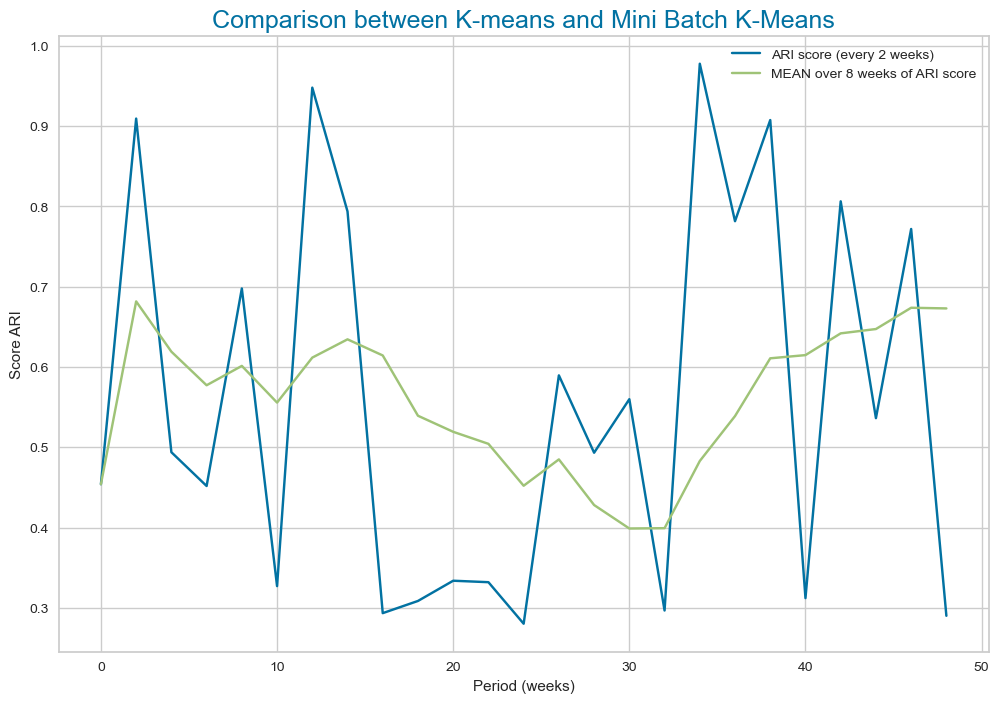

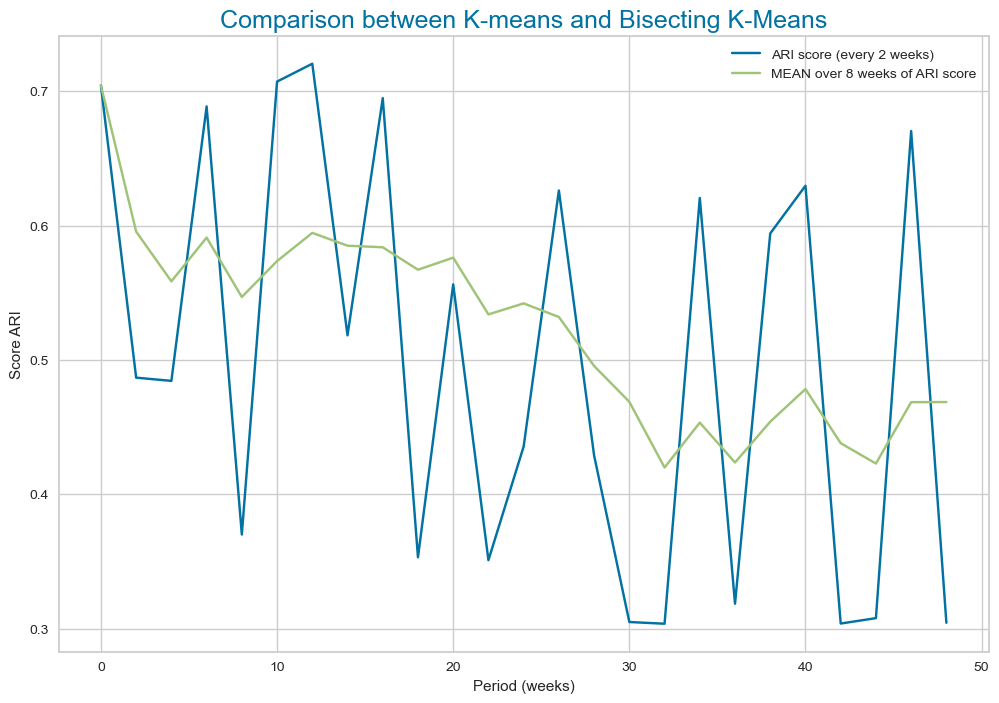

In [8]:
ari_df = pd.DataFrame({'period':[((time-time_1)/np.timedelta64(2,'W'))*2 for time in ari_time],
                       'mini_ARI_mean':mini_ari_mean_score,
                       'mini_ARI': mini_ari_score,
                       'bi_ARI_mean':bi_ari_mean_score,
                       'bi_ARI': bi_ari_score,
                      })

fig= plt.figure(figsize=(12,8))
sns.lineplot(data=ari_df, x="period", y="mini_ARI", label='ARI score (every 2 weeks)')
sns.lineplot(data=ari_df, x="period", y="mini_ARI_mean", label='MEAN over 8 weeks of ARI score')
plt.xlabel("Period (weeks)")
plt.ylabel("Score ARI")
plt.title("Comparison between K-means and Mini Batch K-Means",
          fontsize=18,
          color="b")
plt.show()
plt.close('all')


fig= plt.figure(figsize=(12,8))
sns.lineplot(data=ari_df, x="period", y="bi_ARI", label='ARI score (every 2 weeks)' )
sns.lineplot(data=ari_df, x="period", y="bi_ARI_mean", label='MEAN over 8 weeks of ARI score' )

plt.xlabel("Period (weeks)")
plt.ylabel("Score ARI")
plt.title("Comparison between K-means and Bisecting K-Means",
          fontsize=18,
          color="b")
plt.show()
plt.close('all')

##### conclusions  :    
    To determine the time of maintenance we calculate the ARI_score between the clusters model calculate with KMeans method and the clusters of BisectingKMeans & MiniBatchKMeans.

    On the plot with the ARI_score with BisectingKMeans we notice a strong inflection after 20 weeks.
    On the plot with the ARI_score with MiniBatchKMeans we notice an inflection after 16 weeks.
    
    We can conclude that it will be necessary to plan maintenance of the segmentation program every 18 weeks initially and then re-test this temporal stability over time in order to refine it.

    It will therefore be necessary to redefine the customer segments at each maintenance.